<a href="https://colab.research.google.com/github/nupursjsu/Advanced-Deep-Learning/blob/master/Project/BreastCancerCNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [3]:
!gdown --id 1kLevdRmyykFfaiUt0A3uSFCRog-mOWSJ

Downloading...
From: https://drive.google.com/uc?id=1kLevdRmyykFfaiUt0A3uSFCRog-mOWSJ
To: /content/combined.zip
4.21GB [01:04, 65.4MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('/content/combined.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/combined')

In [5]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/combined/combined/train/1',224))
malign_train = np.array(Dataset_loader('/content/combined/combined/train/0',224))
benign_test = np.array(Dataset_loader('/content/combined/combined/test/1',224))
malign_test = np.array(Dataset_loader('/content/combined/combined/test/0',224))

100%|██████████| 1068/1068 [00:15<00:00, 67.40it/s]


In [8]:
benign_train_label = np.ones(len(benign_train))
malign_train_label = np.zeros(len(malign_train))
benign_test_label = np.ones(len(benign_test))
malign_test_label = np.zeros(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

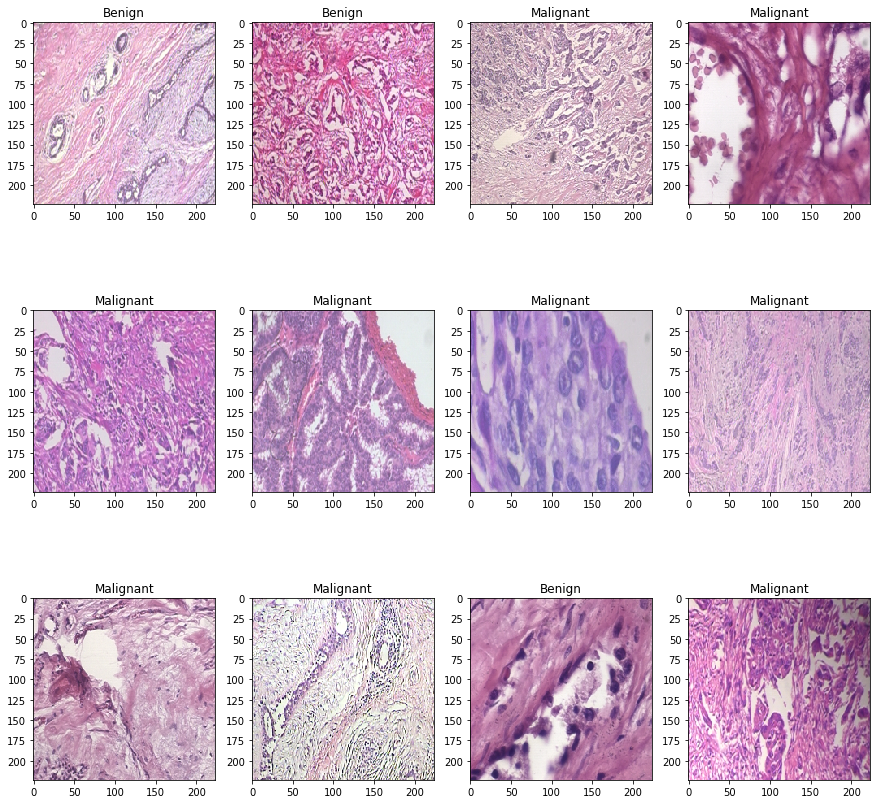

In [10]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [11]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [12]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74842112/74836368 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [13]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
313/312 [==============================] - 60s 190ms/step - loss: 0.4747 - accuracy: 0.7994 - val_loss: 0.6405 - val_accuracy: 0.7628
Epoch 2/20
313/312 [==============================] - 55s 177ms/step - loss: 0.3394 - accuracy: 0.8621 - val_loss: 0.1459 - val_accuracy: 0.9369
Epoch 3/20
313/312 [==============================] - 55s 175ms/step - loss: 0.2782 - accuracy: 0.8879 - val_loss: 0.1922 - val_accuracy: 0.9297
Epoch 4/20
313/312 [==============================] - 54s 174ms/step - loss: 0.2612 - accuracy: 0.8947 - val_loss: 0.1367 - val_accuracy: 0.9465
Epoch 5/20
313/312 [==============================] - 55s 176ms/step - loss: 0.2409 - accuracy: 0.9001 - val_loss: 0.2455 - val_accuracy: 0.9042
Epoch 6/20
313/312 [==============================] - 57s 182ms/step - loss: 0.2172 - accuracy: 0.9125 - val_loss: 0.1519 - val_accuracy: 0.9361
Epoch 7/20
313/312 [==============================] - 

In [15]:
model.save("my_h5_model.h5")

In [ ]:
# model = build_model(resnet ,lr = 1e-4)
# model.load_weights('/content/weights.best.hdf5')

In [22]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('my_h5_model.h5')

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=1e-4),
        metrics=['accuracy']
    )

img = cv2.imread('/content/combined/combined/test/0/SOB_M_DC-14-11520-200-001.png')
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])

classes = model.predict_classes(img)

print(classes)

[0]


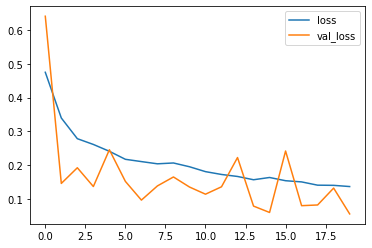

In [24]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()